# Analyze tweet performance

<hr style="border:2px solid gray"> </hr>

Let's take a look at the tweet data collected in the "0 - Extracting tweet information using API search" notebook.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
mdf = pd.read_hdf("bin/2021-01-02-mdf.hdf")
mdf

tweet_id      tweet_datetime  \
reading       0     1345539452429590531 2021-01-03 01:16:19   
              1     1345538965529649154 2021-01-03 01:14:22   
              2     1345500721731530757 2021-01-02 22:42:24   
              3     1345446524109651973 2021-01-02 19:07:03   
              4     1345440843956514817 2021-01-02 18:44:28   
...                                 ...                 ...   
inspirational 1093  1343248050484113409 2020-12-27 17:31:06   
              1094  1343247791427117056 2020-12-27 17:30:04   
              1095  1343247774402408449 2020-12-27 17:30:00   
              1096  1343245767499243521 2020-12-27 17:22:01   
              1097  1343243057102270466 2020-12-27 17:11:15   

                                                           tweet_body  \
reading       0     Read my other published poems at https://t.co/...   
              1     What you seek is seeking you. Rumi\n#lockdownu...   
              2     We are born human - law must keep us so.\n#Loc...   
              3     "To read is to fly: it is to soar to a point o...   
              4     #SelfMusings #WritingCommunity #writerslift #w...   
...                                                               ...   
inspirational 1093  I wanted revenge but God gave me peace and an ...   
              1094  This is powerful advice.\n\n#inspirationalquot...   
              1095  Art for Sale\nSHOP HERE: https://t.co/L6LUUEcK...   
              1096  Do it with love. \n#quotes\n#Inspirational quo...   
              1097  #dink #dinklife #dinklifestyle #absurd #albert...   

                   tweet_media num_retweets num_favorites  
reading       0          photo            1             1  
              1            NaN            0             0  
              2            NaN            0             0  
              3          photo            0             0  
              4          photo            0             2  
...                        ...          ...           ...  
inspirational 1093         NaN            0             0  
              1094       photo            6            13  
              1095       photo            1             2  
              1096       photo            0             0  
              1097       photo            0             0  

[4133 rows x 6 columns]

## Remove extreme outliers

<IPython.core.display.Javascript object>


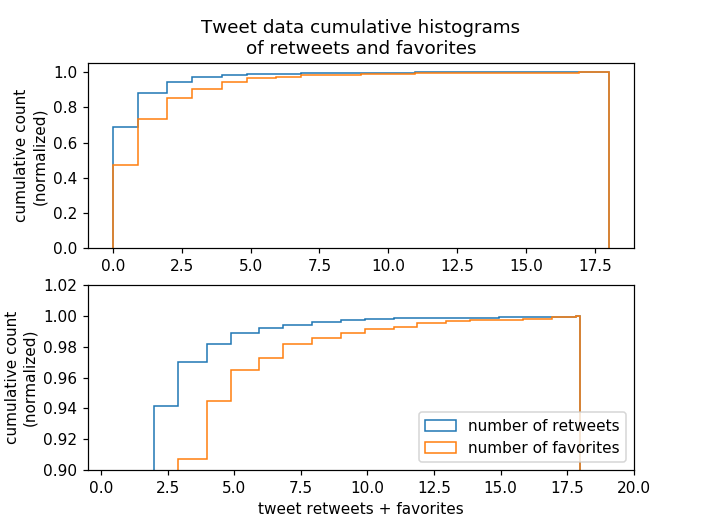

In [15]:
def myhist(data,label=""):
    plt.hist(
        data,
        bins=100,
        density=True,
        cumulative=True,
        histtype="step",
        label=label)

# examine any outliers using histograms:
plt.figure()
plt.subplot(2,1,1)
plt.title("Tweet data cumulative histograms\nof retweets and favorites")
myhist(mdf.num_retweets)
myhist(mdf.num_favorites)
plt.ylabel("cumulative count\n(normalized)")
plt.subplot(2,1,2)
myhist(mdf.num_retweets, label="number of retweets")
myhist(mdf.num_favorites, label="number of favorites")
plt.xlabel("tweet retweets + favorites")
plt.ylabel("cumulative count\n(normalized)")
plt.xlim([-0.5,20])
plt.ylim([0.9,1.02])
plt.legend(loc="lower right")

In [4]:
mdf = mdf[
    (mdf.num_retweets <= 20) &
    (mdf.num_favorites <= 20)].copy()
mdf.index = mdf.index.remove_unused_levels()

In [5]:
mdf10 = mdf[
    (mdf.num_retweets >= 5) &
    (mdf.num_favorites >= 5)].copy()
mdf10.index = mdf10.index.remove_unused_levels()

<IPython.core.display.Javascript object>


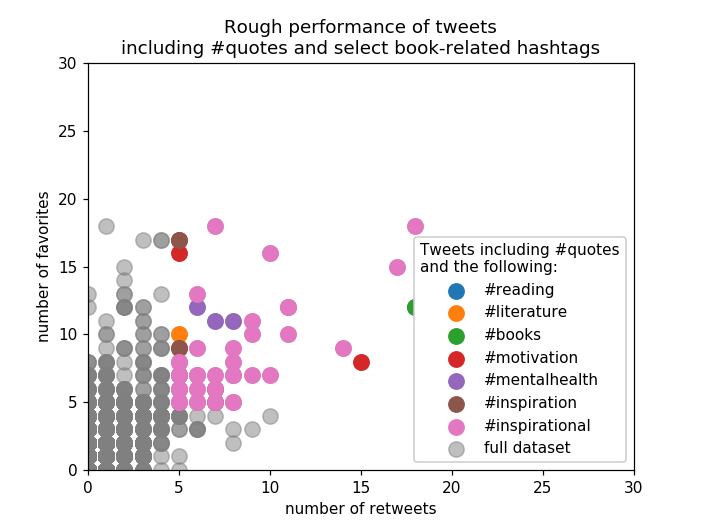

Text(0, 0.5, 'number of favorites')

In [23]:
# scatterplot: num-favorites vs num-retweets, with 
# the index hashtags as colors.
plt.figure()
plt.title("Rough performance of tweets\nincluding #quotes and select book-related hashtags")

# highlight tweets that garnered at least 10 retweets and
# at least 10 favorites:
for tag in mdf10.index.levels[0]:
    df = mdf10.loc[tag]
    plt.scatter(
        df.num_retweets,
        df.num_favorites,
        label="#%s" %tag,
        s=100,
        zorder=10)

# all tweet data:
plt.scatter(
    mdf.num_retweets,
    mdf.num_favorites,
    label="full dataset",
    color="gray",
    alpha=0.5,
    s=100,
    zorder=1)
    
# finish plot:
plt.xlim([0,30])
plt.ylim([0,30])
l = plt.legend(
    title="Tweets including #quotes\nand the following:",
    facecolor="white",
    framealpha=1,
    loc="lower right")
l.set_zorder(20) #legend on top of data
plt.xlabel("number of retweets")
plt.ylabel("number of favorites")
    

## Compare tweets with photos and tweets without photos

<IPython.core.display.Javascript object>


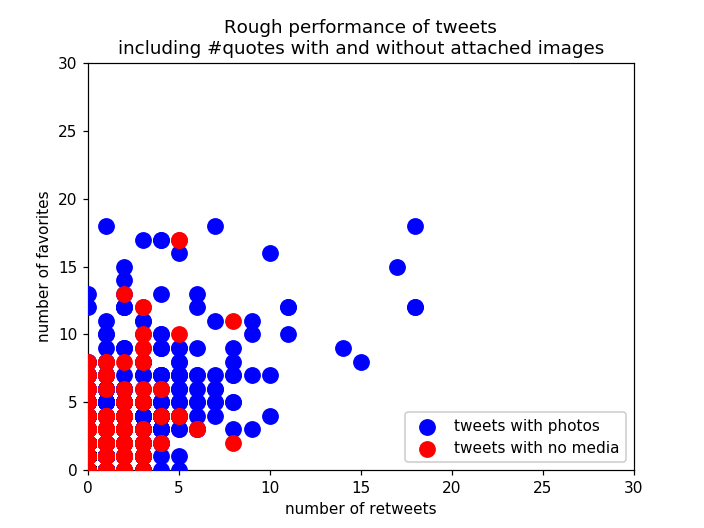

Text(0, 0.5, 'number of favorites')

In [22]:
mdf_with_photos = mdf[mdf.tweet_media=="photo"]
mdf_no_media = mdf[mdf.tweet_media.isnull()]
plt.figure()
plt.title("Rough performance of tweets\nincluding #quotes with and without attached images")

# tweets with photos:
plt.scatter(
    mdf_with_photos.num_retweets,
    mdf_with_photos.num_favorites,
    label="tweets with photos",
    color="blue",
    s=100,
    zorder=10)

# all tweet data:
plt.scatter(
    mdf_no_media.num_retweets,
    mdf_no_media.num_favorites,
    label="tweets with no media",
    color="red",
    s=100,
    zorder=10)
    
# finish plot:
plt.xlim([0,30])
plt.ylim([0,30])
l = plt.legend(
    facecolor="white",
    framealpha=1,
    loc="lower right")
l.set_zorder(20) #legend on top of data
plt.xlabel("number of retweets")
plt.ylabel("number of favorites")

## Relationship between tweet hashtags, tweet words, and tweet interactions

In [8]:
def extract_hashtags(s):
    s = s.replace("\n", " ")
    words = s.split(" ")
    tags = [x for x in words if "#" in x]
    tags = [x[1:] for x in tags]
    return ";".join(tags)

def count_hashtags(s):
    s = extract_hashtags(s)
    return len(s.split(";"))

def count_words(s):
    s = s.replace("\n", " ")
    words = s.split(" ")
    words = [x for x in words if "#" not in x]
    words = [x for x in words if "https" not in x]
    words = [x for x in words if "http" not in x]
    return len(words)

def count_characters(s):
    return len(s)

mdf["hashtags"] = mdf.tweet_body.apply(extract_hashtags)
mdf["num_hashtags"] = mdf.tweet_body.apply(count_hashtags)
mdf["num_words"] = mdf.tweet_body.apply(count_words)
mdf["num_characters"] = mdf.tweet_body.apply(count_characters)
mdf["num_interactions"] = mdf.num_retweets + mdf.num_favorites

Pretty clear that tweets with more words relative to hashtags get more interactions. 

<IPython.core.display.Javascript object>


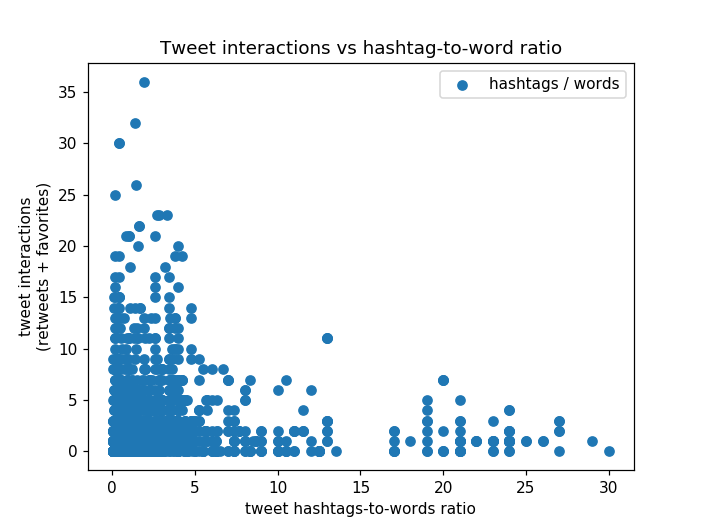

Text(0, 0.5, 'tweet interactions\n(retweets + favorites)')

In [24]:
# scatterplot of word count vs hashtag count, 
# with tweet interactions as a heat map:
plt.figure()
plt.title("Tweet interactions vs hashtag-to-word ratio")
plt.scatter(
    mdf.num_hashtags/mdf.num_words,
    mdf.num_interactions,
    label="hashtags / words")
plt.legend()
plt.xlabel("tweet hashtags-to-words ratio")
plt.ylabel("tweet interactions\n(retweets + favorites)")

Let's see if this holds for each subset.

<IPython.core.display.Javascript object>


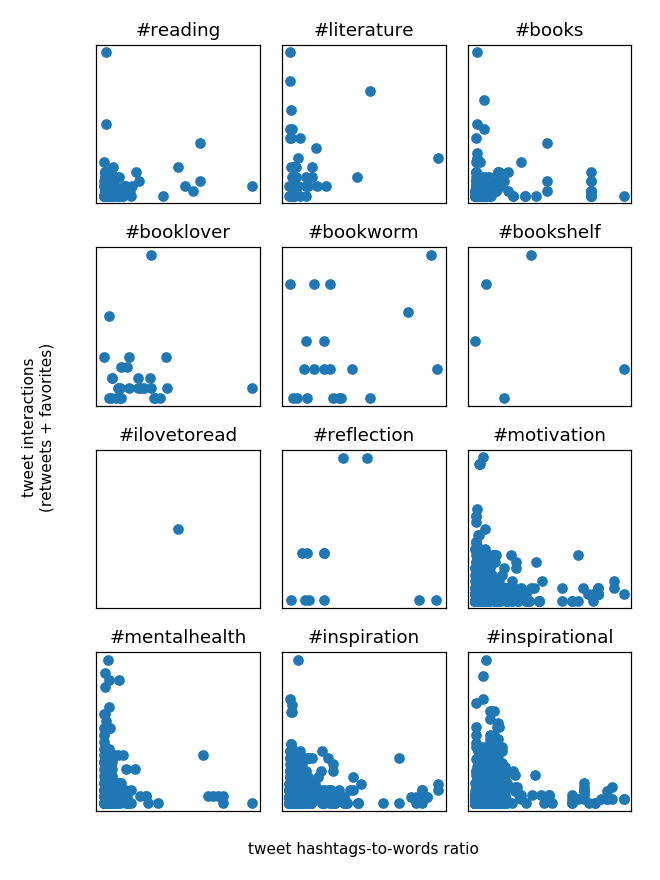

In [53]:
fig, axes = plt.subplots(4,3,figsize=(6,8),sharex=True,sharey=True)
for subplot_id, tag in enumerate(mdf.index.levels[0]):
    df = mdf.loc[tag]
    plt.subplot(4,3,subplot_id+1)
    plt.title("#%s" %tag)
    plt.scatter(
        df.num_hashtags/df.num_words,
        df.num_interactions)
    plt.xticks([])
    plt.yticks([])

# master axis labels:
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("tweet hashtags-to-words ratio")
plt.ylabel("tweet interactions\n(retweets + favorites)")

# fit figure better:
plt.tight_layout()